In [19]:
# data setup imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# sklearn imports
import sklearn as sk
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

file_name = "../drunk_driving_violations.csv"
drunk_driving_df = pd.read_csv(file_name)

In [20]:
# Separate feature columns from class label column
drunk_label_df = drunk_driving_df['Contributed To Accident']
drunk_features_df = drunk_driving_df.drop(['Contributed To Accident'], axis=1)

# Standardize dataset features so that all values have mean=0 and variance=1
# Not standardizing class labels.
scaler_drunk_features_df = StandardScaler().fit(drunk_features_df)
rescaled_drunk_features_df = scaler_drunk_features_df.transform(drunk_features_df)

print(rescaled_drunk_features_df)

[[ 1.34224998 -0.8559975  -0.1810344  ... -0.07810469 -1.02214165
  -1.91598285]
 [ 1.34224998 -0.73952048 -0.1810344  ... -0.07810469  1.28883285
   0.52157388]
 [-0.35584203  1.70649687 -0.1810344  ... -0.07810469 -1.02214165
   0.52157388]
 ...
 [-0.35584203 -0.62304346 -0.1810344  ... -0.07810469 -1.02214165
   0.52157388]
 [-0.9218727  -0.73952048 -0.1810344  ... -0.07810469 -1.02214165
   0.52157388]
 [-0.9218727  -0.8559975  -0.1810344  ... -0.07810469 -1.02214165
   0.52157388]]


In [32]:
############# PREDICTION WITH DECISION TREES ####################
# Train a decision tree with holdout method, evaluate on test set
drunk_df_train_features, drunk_df_test_features, drunk_df_train_label, drunk_df_test_label = train_test_split(rescaled_drunk_features_df, drunk_label_df, train_size = 0.8, test_size = 0.2)
print("Training Set Size: ", len(drunk_df_train_label))
print("Test Set Size: ", len(drunk_df_test_label))

tree_classifier = DecisionTreeClassifier(criterion="entropy")
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
prediction_array = tree_classifier.predict(drunk_df_test_features)
print("Accuracy of DecisionTree holdout(entropy): \n", accuracy_score(drunk_df_test_label.values, prediction_array))

tree_classifier = DecisionTreeClassifier(criterion="gini", max_depth=10)
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
prediction_array = tree_classifier.predict(drunk_df_test_features)
print("Accuracy of DecisionTree holdout(gini and maxDepth 10): \n", accuracy_score(drunk_df_test_label.values, prediction_array))

tree_classifier = DecisionTreeClassifier(criterion="entropy", min_samples_split=5, min_samples_leaf=10)
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
prediction_array = tree_classifier.predict(drunk_df_test_features)
print("Accuracy of DecisionTree holdout(entropy, maxSamplesSplit 5, minSampleLeaf 10): \n", accuracy_score(drunk_df_test_label.values, prediction_array))

# Prediction accuracy is too high - the cost of this prediction result would be great!

tree_classifier = DecisionTreeClassifier(criterion="entropy", min_samples_split=5, min_samples_leaf=10)
tree_classifier = tree_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
accuracy_of_folds = cross_val_score(estimator=tree_classifier, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Accuracy of DecisionTree with 10 fold crossval: \n", accuracy_of_folds.mean())

Training Set Size:  14117
Test Set Size:  3530
Accuracy of DecisionTree holdout(entropy): 
 0.871671388101983
Accuracy of DecisionTree holdout(gini and maxDepth 10): 
 0.9235127478753541
Accuracy of DecisionTree holdout(entropy, maxSamplesSplit 5, minSampleLeaf 10): 
 0.9220963172804533
Accuracy of DecisionTree with 10 fold crossval: 
 0.9249836797139398


In [23]:
# Avoid overfitting! Let's try to get the best parameters...
criteriaNums = [5,8,10,13]

parameters = {'max_depth': criteriaNums, 'min_samples_leaf': criteriaNums, 'max_features': criteriaNums[:3]}
newTreeClassifier = DecisionTreeClassifier(criterion="entropy")
newTreeClassifier = newTreeClassifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
gscv = GridSearchCV(estimator=newTreeClassifier, param_grid=parameters, cv=10)
gscv.fit(drunk_df_train_features, drunk_df_train_label)

print("Decision Tree Best Parameter Values: ", gscv.best_params_)
print("Decision Tree Accuracy with best parameters tested: ", gscv.best_score_)

Decision Tree Best Parameter Values:  {'max_depth': 5, 'max_features': 5, 'min_samples_leaf': 13}
Decision Tree Accuracy with best parameters tested:  0.929871785790182


In [24]:
accuracyOfEachFold = cross_val_score(estimator=gscv, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Decision Tree Official Accuracy: ", accuracyOfEachFold.mean())

Decision Tree Official Accuracy:  0.9291637495908782


Accuracy of Naive-Bayes 10-fold cross validation:  0.07749547566789512
Confusion Matrix: 
[[  108 13021]
 [    2   986]]
Classification Report: 
             precision    recall  f1-score   support

          0       0.98      0.01      0.02     13129
          1       0.07      1.00      0.13       988

avg / total       0.92      0.08      0.02     14117

Horrible f1-score - there are too many false negatives!


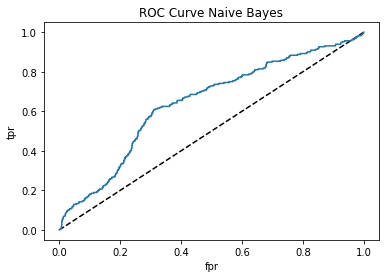

The area under the curve:  0.6423034597770854


In [26]:
############# Gaussian Naive-Bayes Classifier ###############
drunk_df_train_features, drunk_df_test_features, drunk_df_train_label, drunk_df_test_label = train_test_split(rescaled_drunk_features_df, drunk_label_df, train_size = 0.8, test_size = 0.2)

nb_classifier = GaussianNB()
nb_classifier = nb_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)
accuracy_of_each_fold = cross_val_score(estimator=nb_classifier, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Accuracy of Naive-Bayes 10-fold cross validation: ", accuracy_of_each_fold.mean())

# Calculate the confusion matrix of this classifier
predictions = cross_val_predict(estimator=nb_classifier, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Confusion Matrix: ")
print(confusion_matrix(y_true=drunk_df_train_label.values, y_pred=predictions))
print("Classification Report: ")
print(classification_report(y_true=drunk_df_train_label.values, y_pred=predictions))
print("Horrible f1-score - there are too many false negatives!")

# Plot ROC curve!
predictions = nb_classifier.predict_proba(drunk_df_test_features)
fpr, tpr, threshold = roc_curve(drunk_df_test_label, predictions[:,1])
plt.plot([0,1],[0,1],'k--') #plot the diagonal line
plt.plot(fpr, tpr, label='NB') #plot the ROC curve
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve Naive Bayes')
plt.show()
print("The area under the curve: ", roc_auc_score(drunk_df_test_label, predictions[:,1]))

In [27]:
############# Neural Network ###############
mlp_classifier = MLPClassifier(hidden_layer_sizes=(1,)) #single hidden layer
mlp_classifier = mlp_classifier.fit(X=drunk_df_train_features, y=drunk_df_train_label)

criteria_nums = [(10,),(20,),(30,),(40,),(50,),(60,)]
activation_fns = ['logistic','tanh', 'relu']

parameters = {'hidden_layer_sizes': criteria_nums, 'activation': activation_fns}
gscv = GridSearchCV(estimator=mlp_classifier, param_grid=parameters, cv=5)
gscv.fit(drunk_df_train_features, drunk_df_train_label)
accuracyOfEachFold = cross_val_score(estimator=gscv, X=drunk_df_train_features, y=drunk_df_train_label, cv=5)
print("Official Accuracy: ", accuracyOfEachFold.mean())

Official Accuracy:  0.9298718554383486


In [ ]:
############## Random Forests ###############
rf_classifier = RandomForestClassifier()
rf_classifier = rf_classifier.fit(drunk_df_train_features, drunk_df_train_label)

depthNums = []
for i in range(35, 56):
    depthNums.append(i)
minSamples = [8, 10, 12]
maxFeatures = ['sqrt', 'log2']

parameters = {'max_depth': depthNums, 'min_samples_leaf': minSamples, 'max_features': maxFeatures}
gscv = GridSearchCV(estimator=rf_classifier, param_grid=parameters, cv=5)
gscv.fit(drunk_df_train_features, drunk_df_train_label)
accuracyOfEachFold = cross_val_score(estimator=gscv, X=drunk_df_train_features, y=drunk_df_train_label, cv=5)
print("Official Accuracy: ", accuracyOfEachFold.mean())

In [25]:
############# K-Nearest Neighbor ###############
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()
knnClassifier = KNeighborsClassifier()

pipe = Pipeline(steps=[('pca', pca), ('knn', knnClassifier)])

# Find the ideal k and features by testing all these options
parameters = {'pca__n_components': list(range(1,13)),
              'knn__n_neighbors': list(range(1,10))}

gscvKNN = GridSearchCV(pipe, param_grid=parameters, cv=5, refit=True)
gscvKNN.fit(drunk_df_train_features, drunk_df_train_label)
print("Best Parameters: ", gscvKNN.best_params_)
print("Accuracy with Best Parameters: ", gscvKNN.best_score_)

KeyboardInterrupt: 

In [ ]:
# (KNN Continued)
# Wrap with another cross-validation and report final accuracy
accuracyOfEachFold = cross_val_score(estimator=gscvKNN, X=drunk_df_train_features, y=drunk_df_train_label, cv=10)
print("Official KNN Accuracy: ", accuracyOfEachFold.mean())